**Import Required Libraries**

In [1]:
import torch     
from torch import Tensor                  
import torch.nn as nn                 
import torch.optim as optim              
import matplotlib.pyplot as plt
import numpy as np
import itertools
from collections import OrderedDict

In [2]:
# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

cpu


Skip the part if you are running your code in local system

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

Load the training data from numpy

In [4]:
d = np.load("antiderivative_aligned_train.npz", allow_pickle=True)
y_train=  d["X"][1].astype(np.float32) #output locations (100,1)
u_train = d["X"][0].astype(np.float32) # input functions (150,100)
s_train = d["y"].astype(np.float32) # output functions (150,100)

**Define Network Archietecture**

In [6]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        #define your sequential model here with activations 
        super(DNN, self).__init__()
        
        # layers have a list of neurons in each layer
        self.layers = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(layers[0], layers[1])),
            ('relu1', nn.Tanh()),
            ('fc2', nn.Linear(layers[1], layers[2])),
            ('relu2', nn.Tanh()),
            ('fc3', nn.Linear(layers[2], layers[3])),
            ('relu3', nn.Tanh()),
            ('fc4', nn.Linear(layers[3], layers[4])),
            ('relu4', nn.Tanh()),
            ('fc5', nn.Linear(layers[4], layers[5])),
            ('relu5', nn.Tanh()),

        ]))

        
    def forward(self, x): #forward pass
        out = self.layers(x)
        return out   

**The DeepONet Archietecture**

In [7]:
class PI_DeepONet():
    def __init__(self, branch_layers, trunk_layers,u_train, y_train, s_train):
        
        self.u_train =  torch.from_numpy(u_train).to(device)      #convert to torch tensor
        self.y_train =  torch.from_numpy(y_train).to(device)      #convert to torch tensor
        self.s_train =  torch.from_numpy(s_train).to(device)      #convert to torch tensor
        
        
        self.branch_net = DNN(branch_layers).to(device)  # The branch Network

        self.trunk_net = DNN(trunk_layers).to(device)    # The trunk Network
        
        branch_params =  list(self.branch_net.parameters())  #extract the network Parameters
        trunk_params =   list(self.trunk_net.parameters())   #extract the network Parameters

        params = branch_params + trunk_params
        
        self.optimizer = torch.optim.LBFGS(params, lr=0.0001) #optimizer

        self.optimizer_Adam = torch.optim.Adam(params, lr=0.0001)

        self.iter = 0    #initiate iteration

    
    def operator_net(self,  u, y):    # Define DeepONet architecture
        B = self.branch_net(u) #output from branch Network
        T = self.trunk_net(y)  #output from branch Network 

        output = torch.matmul(B, torch.transpose(T,0,1))
        
   
        return output
        
    # Define operator loss
    def loss_operator(self, u, y):
        
        pred = self.operator_net(u, y) #predict
        loss =  torch.mean((pred - self.s_train)**2) #loss
        return loss
        
    def loss_func(self):   #Define loss function for optimization step
        loss = self.loss_operator(self.u_train, self.y_train)
        self.optimizer.zero_grad()
        loss.backward()
        return loss
    
    def train(self, nIter):
        model_loss=np.array([])
        for epoch in range(nIter):
            loss= self.loss_operator(self.u_train,self.y_train)
            
             # Backward and optimize
           
            self.optimizer_Adam.zero_grad()
            loss.backward()
            self.optimizer_Adam.step()

            model_loss=np.append(model_loss,loss.detach().cpu().numpy())

            if epoch % 1000 == 0:
               # print loss and iteration
                print('Iteration: %d, Loss: %.3e' % (epoch, loss.item()))
                
        # Backward and optimize
        self.optimizer.step(self.loss_func)
        
        return model_loss 
             
    # Evaluates predictions at test points  
    def predict_s(self, u_star,y_star):
        u_star = torch.from_numpy(u_star).to(device)
        y_star = torch.from_numpy(y_star).to(device)
        s = self.operator_net(u_star, y_star) #predict
        s = s.detach().cpu().numpy()
        return s

**Train the Model**

In [8]:
# Initialize model

branch_layers = [100, 50, 50, 50, 50, 50]
trunk_layers =  [1, 50, 50, 50, 50, 50]

model = PI_DeepONet(branch_layers, trunk_layers,u_train, y_train, s_train)

 
'Neural Network Summary'
print(model)
nIter=10000
loss=model.train(nIter)

Iteration: 0, Loss: 3.095e-01
Iteration: 1000, Loss: 3.019e-03
Iteration: 2000, Loss: 3.847e-04
Iteration: 3000, Loss: 3.051e-04
Iteration: 4000, Loss: 2.609e-04
Iteration: 5000, Loss: 6.285e-05
Iteration: 6000, Loss: 3.467e-05
Iteration: 7000, Loss: 5.692e-05
Iteration: 8000, Loss: 2.253e-05
Iteration: 9000, Loss: 1.922e-05


**Load Test Data**

In [11]:
d = np.load("antiderivative_aligned_test.npz", allow_pickle=True) 
B=d["X"][0].astype(np.float32)                                              #( 1000, 100)
u_test = d["X"][0].astype(np.float32); y_test=d["X"][1].astype(np.float32)  #( 1000, 100)
s_test = d["y"].astype(np.float32)                                          #( 1000, 100)

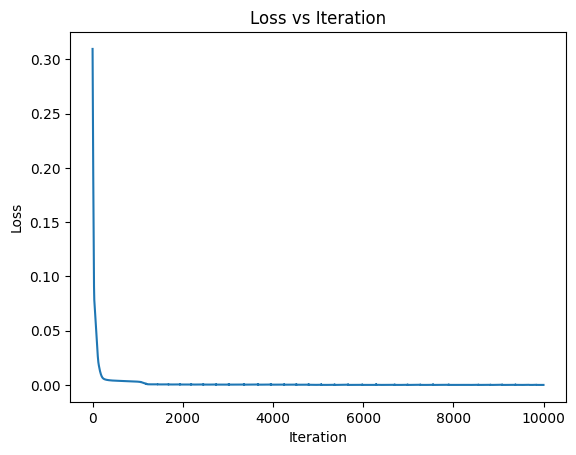

In [10]:
#Model Predictions 
s_pred = model.predict_s(u_test, y_test)

# Plot Loss
plt.figure()
plt.plot(loss)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss vs Iteration')
plt.show()

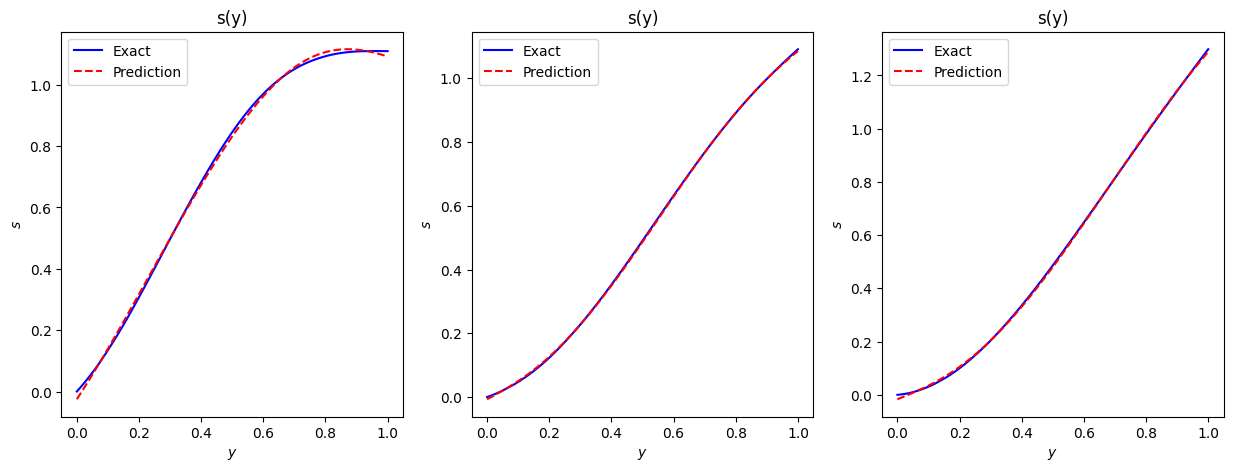

In [11]:
# Plot Visualization

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(y_test, s_test[0,:], 'b-', label='Exact')
ax[0].plot(y_test, s_pred[0,:], 'r--', label='Prediction')
ax[0].set_xlabel('$y$')
ax[0].set_ylabel('$s$')
ax[0].set_title('s(y)')
ax[0].legend()

ax[1].plot(y_test, s_test[1,:], 'b-', label='Exact')
ax[1].plot(y_test, s_pred[1,:], 'r--', label='Prediction')
ax[1].set_xlabel('$y$')
ax[1].set_ylabel('$s$')
ax[1].set_title('s(y)')
ax[1].legend()

ax[2].plot(y_test, s_test[2,:], 'b-', label='Exact')
ax[2].plot(y_test, s_pred[2,:], 'r--', label='Prediction')
ax[2].set_xlabel('$y$')
ax[2].set_ylabel('$s$')
ax[2].set_title('s(y)')
ax[2].legend()

plt.show()